In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

%matplotlib inline

In [2]:
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = torch.argmax(y_h)
            fout.write(f"\n{i},{int(y)}")

In [4]:
train_data = None
test_data = None
encoder = OneHotEncoder()

with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)

# Выберем размер тренировочной выборки
m = int (0.85 * train_data['data'].shape[0])

# Выберем тренировочную выборку
X_train = train_data['data'][:m:]
Y_train = train_data['target'][:m:]
Y_train_oh = torch.FloatTensor(list(map(lambda x : encoder.transform(x), Y_train)))

# Выберем валидационную выборку
X_valid = train_data['data'][m::]
Y_valid = train_data['target'][m::]
Y_valid_oh = torch.FloatTensor(list(map(lambda x : encoder.transform(x), Y_valid)))

# Нормируем признаки
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0)

X_train  = torch.from_numpy ((X_train - mean) / (std + 1e-10)).float()
X_valid  = torch.from_numpy ((X_valid - mean) / (std + 1e-10)).float()
X_test   = torch.from_numpy ((test_data['data'] - mean) / (std + 1e-10)).float()

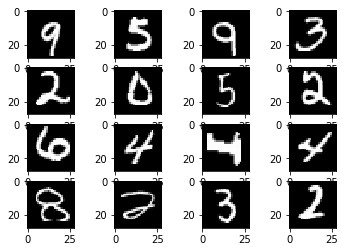

In [5]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Определение слоев сети

In [6]:
class Dense:
    def __init__ (self, in_size, out_size, rlambda = 0.0):
        self.W = torch.randn(out_size, in_size) * np.sqrt(2 / (out_size + in_size))
        self.b = torch.zeros(out_size, )
        self.rlambda = rlambda

    def forward (self, x):
        self.x = x # запоминаем для обратного перехода
        return torch.matmul(self.W, x) + self.b
    
    def backward (self, dz, lr = 0.001):
        # вычисляем градиенты по параметрам
        self.dW = torch.ger(dz, self.x)
        self.db = dz
        
        # вычисляем производную по входу
        self.dx = torch.matmul(self.W.t(), dz)
            
        # обновляем веса
        self.W -= (self.W * self.rlambda + self.dW) * lr
        self.b -= lr * self.db
        
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [7]:
class Max:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [8]:
class Softmax: 
    def forward(self, x):
        self.x = x
        exp = torch.exp (x - torch.max(x))
        return exp / exp.sum()
    
    def backward(self, dz, lr=0.001):
        P  = self.forward(self.x)
        return torch.matmul((P * torch.eye(self.x.shape[0]) - torch.ger (P, P)), dz)

In [9]:
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        L = -1 * y_true * torch.log (y_hat + 1e-10)
        return L.sum()
    
    def backward(self, dz, lr=0.001):
        return -1 * self.y_true / (self.y_hat + 1e-10)

In [10]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = torch.ones(*x.shape)
            return x
        
        self.mask = ((torch.rand(*x.shape) > self.p) * (1 / (1.0 - self.p))).float()
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

# Опеределение самой сети

In [11]:
class MnistNet:
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 300, rlambda)
        self.m1 = Max()
        self.dr = Dropout (0.2)
        self.d2 = Dense(300, 10, rlambda)
        self.m2 = Max()
        self.s  = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.dr.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.dr.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz
    
    def fit(self, X_test, Y_test, Y_test_oh, loss, lr):
        L = 0.
        acc  = 0.
        
        for i in range(X_test.shape[0]):
            
            x    = X_test[i]
            y    = Y_test[i]
            y_oh = Y_test_oh[i]
            y_h  = self.forward(x)
            
            L += loss.forward(y_oh, y_h)
            dz = loss.backward(1, lr)
            dz = self.backward(dz, lr)
            
            if ((torch.argmax(y_h).float()) == y):
                acc += 1.
                
        L   /= Y_test.shape[0]
        acc /= Y_test.shape[0]
            
        return L, acc

# Обучение сети

In [12]:
net = MnistNet(0.001)
loss = CrossEntropy()
lr = 0.0002
L_train = []
L_test = []
Acc_train = []
Acc_test = []

for iter in range(100):
    L1, acc1 = net.fit (X_train, Y_train, Y_train_oh, loss, lr)
    L_train.append (L1)
    Acc_train.append (acc1)
    
    L2   = 0.
    acc2 = 0.
    
    for i in range(X_valid.shape[0]):
        x    = X_valid[i]
        y    = Y_valid[i]
        y_oh = Y_valid_oh[i]
        y_h  = net.forward(x)
        
        L2 += loss.forward(y_oh, y_h)
        
        if (torch.argmax (y_h) == y):
            acc2 += 1.

    L2   /= Y_valid.shape[0]
    acc2 /= Y_valid.shape[0]
    
    L_test.append (L2)
    Acc_test.append (acc2)
    
    print(f"Epoch {iter + 1}:")
    print(f"\tloss.\tTrain : {L1}\tTest : {L2}")
    print(f"\tacc.\tTrain : {acc1}\tTest : {acc2}")

Epoch 1:
	loss.	Train : 0.7152069807052612	Test : 0.4084084630012512
	acc.	Train : 0.7985882352941176	Test : 0.8902857142857142
Epoch 2:
	loss.	Train : 0.3248562514781952	Test : 0.3360818326473236
	acc.	Train : 0.9066890756302521	Test : 0.9079365079365079
Epoch 3:
	loss.	Train : 0.26553791761398315	Test : 0.3021947145462036
	acc.	Train : 0.9216806722689076	Test : 0.9175873015873016
Epoch 4:
	loss.	Train : 0.2334483116865158	Test : 0.2816503643989563
	acc.	Train : 0.9324817927170869	Test : 0.9258412698412698
Epoch 5:
	loss.	Train : 0.21080748736858368	Test : 0.2643241882324219
	acc.	Train : 0.9381512605042017	Test : 0.9295238095238095
Epoch 6:
	loss.	Train : 0.191885307431221	Test : 0.2534445822238922
	acc.	Train : 0.9440448179271709	Test : 0.9316825396825397
Epoch 7:
	loss.	Train : 0.17954279482364655	Test : 0.24806591868400574
	acc.	Train : 0.9475406162464985	Test : 0.9324444444444444
Epoch 8:
	loss.	Train : 0.16750246286392212	Test : 0.23722399771213531
	acc.	Train : 0.95090196078431

KeyboardInterrupt: 

# Рисуем графики

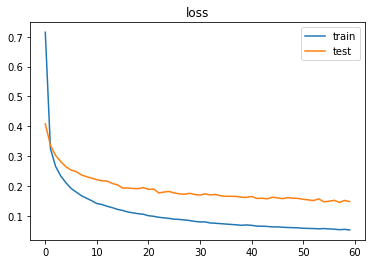

In [13]:
plt.title('loss')
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend()

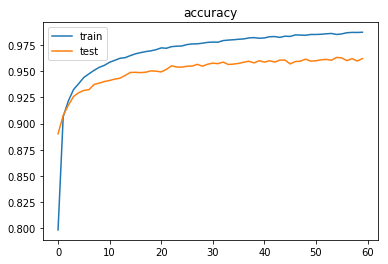

In [14]:
plt.title('accuracy')
plt.plot(Acc_train, label='train')
plt.plot(Acc_test, label='test')
plt.legend()

# Формируем submission и заливаем его на kaggle

In [15]:
make_submission(X_test, net)